# Gender Detection using profile images

**`Goal`:** Determine the gender of the freelancer using the profile images. This is the next pass on gender detection after a failed attempt to predict using firstname

### 1. Load packages

In [ ]:
import cv2
import urllib
import pandas as pd
import numpy as np
from glob import glob
from time import sleep
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

### 2. Load the data

In [ ]:
df = pd.read_csv('../data/gender-annotated/cleaned-gender-annotated-v2.csv')

#Get profiles with unpredicted genders
missing_preds = df.query("gender == 'low_confidence' ")
missing_preds.head()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3229: DtypeWarning: Columns (598,599) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,search_query,name,gender,profile_link,location,hourly_rate,pay_grade,avg_rating,num_reviews,num_recommendations,...,pct_certifications_requirements_engineering_1,skill_furniture_removalist,skill_workday_security,skill_oracle_ebs_tech_integration,pct_certifications_google_webmaster_central_1,skill_modx,skill_cubecart,skill_phaser,skill_drilling_engineering,skill_casperjs
4,designer,Shea,low_confidence,https://www.freelancer.com/u/blaqsupply,Cockeysville,25.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,designer,Dnard,low_confidence,https://www.freelancer.com/u/dnard1,Addison,50.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,designer,Cursed,low_confidence,https://www.freelancer.com/u/CursedMoonX,Minneapolis,15.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,designer,Dyllen,low_confidence,https://www.freelancer.com/u/DyllenGeorge,Fayetteville,16.0,3.1,5.0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,designer,Thayer,low_confidence,https://www.freelancer.com/u/thayerenewport,New Bedford,50.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
missing_preds.shape

(1775, 2266)

### 3. Get profile image for users

In [ ]:
class ProfileImageScraper:

    def __init__(self,urls,start_idx):

        #Store the list of URLs to extract images from
        self.urls = urls

        #Counter to track the image number (for storage purposes)
        self.img_no = start_idx

    def get_profile_image(self,url):

        options = Options()
        options.add_argument("--headless")
        options.add_argument('--no-sandbox')

        #Create browser instance
        self.browser = webdriver.Chrome(options=options)

        try:
            #Get the starting webpage and wait sometime for elements to load
            self.browser.get(url)
            sleep(2.5)
        
        except:
            
            #Close the browser when done
            self.browser.close()

            return

        try:
            #Get the image source from the page
            src = self.browser.find_element(By.CSS_SELECTOR, "img[alt='User Avatar']").get_attribute('src')

            #Save the image
            urllib.request.urlretrieve(src, f"/work/DS4SG-Gender-Inequality/data/profile-images/{self.img_no}.png")

        except:
            #Close the browser when done
            self.browser.close()

            return
        
        #Close the browser when done
        self.browser.close()
        

    
    def run(self):

        #Iterate through the user profiles
        for url in self.urls: 

            #Increment image number tracker
            self.img_no += 1

            #Get the profile image
            self.get_profile_image(url)

            #Sleep for sometime before next try
            sleep(1.5)
        
        #Close the browser when done
        self.browser.quit() 




In [ ]:
#DON'T FORGET TO CHANGE STARTING NUMBER
idx=1355
img_scraper = ProfileImageScraper(missing_preds.profile_link.to_list()[idx:],idx)
img_scraper.run()

In [ ]:
#These profiles/accounts/images do not exist
[i for i in range(1, 1776) if f'../data/profile-images/{i}.png' not in glob('../data/profile-images/*.png')]

[1, 301, 763, 1194, 1231, 1702]

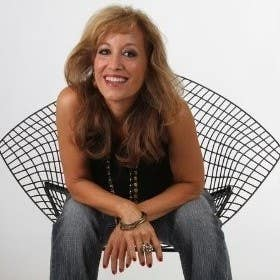

In [ ]:
from IPython.display import display, Image
display(Image(filename='../data/profile-images/1775.png'))

### 4. Gender detection code
Adapted from: https://github.com/x4nth055/pythoncode-tutorials/tree/master/machine-learning/face-gender-detection

In [ ]:
class ImageGenderDetection:

    def __init__(self,img_list=None,face_conf_thresh=0.5,gender_conf_thresh=0.95):

        if img_list is None:
            return ValueError('Please pass in a list of images to predict gender for')

        # The gender model architecture
        self.GENDER_MODEL = '../models/deploy_gender.prototxt'

        # The gender model pre-trained weights
        self.GENDER_PROTO = '../models/gender_net.caffemodel'

        # Each Caffe Model impose the shape of the input image also image preprocessing is required like mean
        # substraction to eliminate the effect of illunination changes
        self.MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

        # Represent the gender classes
        self.GENDER_LIST = ['male', 'female']

        # Face model pretrained weights
        self.FACE_PROTO = "../models/deploy.prototxt.txt"

        # Face detection model architecture
        self.FACE_MODEL = "../models/res10_300x300_ssd_iter_140000_fp16.caffemodel"

        # Load face Caffe model
        self.face_net = cv2.dnn.readNetFromCaffe(self.FACE_PROTO, self.FACE_MODEL)

        # Load gender prediction model
        self.gender_net = cv2.dnn.readNetFromCaffe(self.GENDER_MODEL, self.GENDER_PROTO)

        # Initialize frame size
        self.frame_width = 1280
        self.frame_height = 720

        #Initialize confidence threshold for face detection
        self.face_conf_thresh = face_conf_thresh

        #Initialize confidence threshold for gender detection
        self.gender_conf_thresh = gender_conf_thresh

        #Paths to the images
        self.img_paths = img_list



    def get_faces(self, frame):
        
        # Convert the frame into a blob to be ready for NN input
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104, 177.0, 123.0))
        
        # Set the image as input to the NN
        self.face_net.setInput(blob)

        # Perform inference and get predictions
        output = np.squeeze(self.face_net.forward())

        # Initialize the result list
        faces = []

        # Loop over the faces detected
        for i in range(output.shape[0]):
            confidence = output[i, 2]
            
            if confidence > self.face_conf_thresh:
                box = output[i, 3:7] * \
                    np.array([frame.shape[1], frame.shape[0],
                            frame.shape[1], frame.shape[0]])
                
                # Convert to integers
                start_x, start_y, end_x, end_y = box.astype(np.int)
                
                # Widen the box a little
                start_x, start_y, end_x, end_y = start_x - \
                    10, start_y - 10, end_x + 10, end_y + 10
                start_x = 0 if start_x < 0 else start_x
                start_y = 0 if start_y < 0 else start_y
                end_x = 0 if end_x < 0 else end_x
                end_y = 0 if end_y < 0 else end_y
                
                # Append to our list
                faces.append((start_x, start_y, end_x, end_y))
        
        return faces


    # from: https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
    def image_resize(self, image, width = None, height = None, inter = cv2.INTER_AREA):
        
        # Initialize the dimensions of the image to be resized and
        # grab the image size
        dim = None
        (h, w) = image.shape[:2]

        # If both the width and height are None, then return the
        # original image
        if width is None and height is None:
            return image

        # Check to see if the width is None
        if width is None:
            # Calculate the ratio of the height and construct the
            # dimensions
            r = height / float(h)
            dim = (int(w * r), height)

        # Otherwise, the height is None
        else:
            # Calculate the ratio of the width and construct the
            # dimensions
            r = width / float(w)
            dim = (width, int(h * r))

        # Resize the image
        return cv2.resize(image, dim, interpolation = inter)


    def predict_gender(self, input_path: str):

        """Predict the gender of the faces showing in the image"""
        
        # Read Input Image
        img = cv2.imread(input_path)

        # Take a copy of the initial image and resize it
        frame = img.copy()
        if frame.shape[1] > self.frame_width:
            frame = self.image_resize(frame, width=self.frame_width)

        # Predict the faces
        faces = self.get_faces(frame)

        # Loop over the faces detected
        # for idx, face in enumerate(faces):
        for i, (start_x, start_y, end_x, end_y) in enumerate(faces):
            face_img = frame[start_y: end_y, start_x: end_x]

            # image --> Input image to preprocess before passing it through our dnn for classification.
            # scale factor = After performing mean substraction we can optionally scale the image by some factor. (if 1 -> no scaling)
            # size = The spatial size that the CNN expects. Options are = (224*224, 227*227 or 299*299)
            # mean = mean substraction values to be substracted from every channel of the image.
            # swapRB=OpenCV assumes images in BGR whereas the mean is supplied in RGB. To resolve this we set swapRB to True.
            blob = cv2.dnn.blobFromImage(image=face_img, scalefactor=1.0, size=(
                227, 227), mean=self.MODEL_MEAN_VALUES, swapRB=False, crop=False)

            # Predict Gender
            self.gender_net.setInput(blob)
            gender_preds = self.gender_net.forward()
            i = gender_preds[0].argmax()
            gender = self.GENDER_LIST[i]
            gender_confidence_score = gender_preds[0][i]

            return gender, gender_confidence_score

    
    def predict_all_profile_genders(self,true_total_imgs,profile_imgs=None):

        if profile_imgs is None:
            profile_imgs = self.img_paths

        #List to store the gender predictions for all the profile images
        gender_preds = []

        #Iterate through all the possible images
        for img_idx in range(1,true_total_imgs+1):

            print('Image ', img_idx)
            
            #Get the target img_path for the particular index
            img_path = f"../data/profile-images/{img_idx}.png"

            #If the image exists in the true images list
            if img_path in profile_imgs:

                try:
                    #Predict the gender of the image
                    gender_pred, conf = self.predict_gender(img_path)
                except:
                    gender_preds.append('prediction_error')
                    continue

                #If the confidence is greater than the set threshold
                if conf >= self.gender_conf_thresh:

                    #Add prediction to list
                    gender_preds.append(gender_pred)

                #If not, mark as low_confidence
                else:
                    gender_preds.append('low_confidence')
            
            #If the image does not exist, mark as no prediction
            else:
                gender_preds.append(np.nan)
        
        return gender_preds


In [ ]:
img_gender_predictor = ImageGenderDetection(glob('../data/profile-images/*.png'))
gender_preds = img_gender_predictor.predict_all_profile_genders(len(missing_preds))

Image  777
Image  778
Image  779
Image  780
Image  781
Image  782
Image  783
Image  784
Image  785
Image  786
Image  787
Image  788
Image  789
Image  790
Image  791
Image  792
Image  793
Image  794
Image  795
Image  796
Image  797
Image  798
Image  799
Image  800
Image  801
Image  802
Image  803
Image  804
Image  805
Image  806
Image  807
Image  808
Image  809
Image  810
Image  811
Image  812
Image  813
Image  814
Image  815
Image  816
Image  817
Image  818
Image  819
Image  820
Image  821
Image  822
Image  823
Image  824
Image  825
Image  826
Image  827
Image  828
Image  829
Image  830
Image  831
Image  832
Image  833
Image  834
Image  835
Image  836
Image  837
Image  838
Image  839
Image  840
Image  841
Image  842
Image  843
Image  844
Image  845
Image  846
Image  847
Image  848
Image  849
Image  850
Image  851
Image  852
Image  853
Image  854
Image  855
Image  856
Image  857
Image  858
Image  859
Image  860
Image  861
Image  862
Image  863
Image  864
Image  865
Image  866
Image  867

In [ ]:
pd.DataFrame(gender_preds).value_counts()

male                810
prediction_error    399
female              332
low_confidence      228
dtype: int64

### 5. Replace missing gender predictions in the original df with the model's gender predictions

In [ ]:
#Run gender identification pipeline on the data
df.loc[df.gender == 'low_confidence','gender'] = gender_preds

In [ ]:
df.gender.value_counts()

male                6560
female              2901
prediction_error     399
low_confidence       228
Name: gender, dtype: int64

In [ ]:
df.query("gender not in ['male','female'] ")

,search_query,name,gender,profile_link,location,hourly_rate,pay_grade,avg_rating,num_reviews,num_recommendations,...,pct_certifications_requirements_engineering_1,skill_furniture_removalist,skill_workday_security,skill_oracle_ebs_tech_integration,pct_certifications_google_webmaster_central_1,skill_modx,skill_cubecart,skill_phaser,skill_drilling_engineering,skill_casperjs
4,designer,Shea,NaN,https://www.freelancer.com/u/blaqsupply,Cockeysville,25.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,designer,Dyllen,low_confidence,https://www.freelancer.com/u/DyllenGeorge,Fayetteville,16.0,3.1,5.0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,designer,Shuishui,prediction_error,https://www.freelancer.com/u/morningcarter,Austin,15.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,designer,Doshianique,prediction_error,https://www.freelancer.com/u/Doshianique,Hope,12.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,designer,Chean,prediction_error,https://www.freelancer.com/u/alstonshek,San Francisco,20.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10003,software engineer,Ananta,prediction_error,https://www.freelancer.com/u/deepakg1995,United States,10.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10005,software engineer,Engineering,prediction_error,https://www.freelancer.com/u/EarleyEngg,Iselin,100.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
10017,software engineer,Mengyu,low_confidence,https://www.freelancer.com/u/kiwini2018,Ashburn,50.0,2.8,5.0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10047,software engineer,Jansu,low_confidence,https://www.freelancer.com/u/Jansu2604,Charlottesville,30.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 6. Drop NAs

In [ ]:
df.gender.isna().sum()

6

In [ ]:
df = df.dropna(subset=['gender'])
df

,search_query,name,gender,profile_link,location,hourly_rate,pay_grade,avg_rating,num_reviews,num_recommendations,...,pct_certifications_requirements_engineering_1,skill_furniture_removalist,skill_workday_security,skill_oracle_ebs_tech_integration,pct_certifications_google_webmaster_central_1,skill_modx,skill_cubecart,skill_phaser,skill_drilling_engineering,skill_casperjs
0,designer,Milen,male,https://www.freelancer.com/u/MsCaddServices,Edmonds,45.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,designer,Jeremy,male,https://www.freelancer.com/u/Conescu,Orinda,90.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,designer,Nichole,female,https://www.freelancer.com/u/NicholeMW,Holly,25.0,4.0,5.0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,designer,Robert,male,https://www.freelancer.com/u/rhoenig1277,Beloit,75.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,designer,Jean-Paul,male,https://www.freelancer.com/u/PaulCarriazo,Miami,19.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,software engineer,Jackie,female,https://www.freelancer.com/u/jackielinn,Tyler,30.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10090,software engineer,Alex,male,https://www.freelancer.com/u/aresnik,Hamden,15.0,0.4,5.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10091,software engineer,Jonathan,male,https://www.freelancer.com/u/tcoffin014,Denham Springs,150.0,0.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10092,software engineer,Dee,female,https://www.freelancer.com/u/IntelligentDee,Arlington,25.0,0.0,0.0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 6. Export CSV for human reannotation

In [ ]:
df.to_csv('../data/gender-annotated/cleaned-gender-annotated-v3.csv',index=False)

In [ ]:
k = img_gender_predictor.predict_gender('img_11.jpeg')
k

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


('female', 0.65566665)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=acc27b92-84be-4130-8026-204943f38189' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>